In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import kruskal, mannwhitneyu, kendalltau, chi2_contingency, f_oneway

In [2]:
path_dataset = '../../Dataset'
path_result = '../../Result'

path_rq12 = os.path.join(path_result, 'RQ12')
path_rq3 = os.path.join(path_result, 'RQ3')

warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", None, "display.max_columns",
              None, 'display.max_colwidth', None)

tools_open_post = [
    'Domino',
    'DVC',
    'Guild AI',
    'MLflow',
    'SigOpt'
]

macro_topic_indexing = {
    0: 'Code Development',
    1: 'Code Management',
    2: 'Computation Management',
    3: 'Data Development',
    4: 'Data Management',
    5: 'Environment Management',
    6: 'Experiment Management',
    7: 'File Management',
    8: 'Model Deployment',
    9: 'Model Development',
    10: 'Model Management',
    11: 'Network Management',
    12: 'Observability Management',
    13: 'Pipeline Management',
    14: 'Security Management',
    15: 'User Interface Management'
}

stackoverflow = 'Stack Overflow'
tool = 'Tool-specific forums'
repo = 'Repository-specific forums'

color_map = {
    stackoverflow: 'rgba(50, 205, 50, 0.7)',
    repo: 'rgba(255, 99, 132, 0.7)',
    tool: 'rgba(100, 149, 237, 0.7)',
}

In [3]:
def filter_open_posts(df):
    df_copy = df.copy()
    for index, row in df_copy.iterrows():
        if ('Tool' in row['Platform']) and (row['Tools'][0] in tools_open_post):
            df_copy.drop(index, inplace=True)
    return df_copy

# Calculate Cramér's V
def CramersV_p(contingency_table):
    chi2, p, _, _ = chi2_contingency(contingency_table)
    n = np.sum(contingency_table)
    min_dim = min(contingency_table.shape)-1  # -1 for degrees of freedom
    Cramers_V = np.sqrt(chi2 / (n * min_dim))
    return Cramers_V, p

# Compute eta-squared
def etaSquared_p(resolved_time_list):
    H, p = kruskal(*resolved_time_list)
    # Get the sum of the lengths of all inner lists
    N = sum(len(inner_list) for inner_list in resolved_time_list)
    eta_squared = H / (N - 1)
    return eta_squared, p

In [4]:
df = pd.read_json(os.path.join(path_rq12, 'macro-topics.json'))
# df['Challenge_contributor_issue_ratio'] = df['Challenge_repo_contributor_count'] / df['Challenge_repo_issue_count']
# df['Challenge_watch_issue_ratio'] = df['Challenge_repo_watch_count'] / df['Challenge_repo_issue_count']

for index, row in df.iterrows():
    if 'Stack' in row['Platform']:
        df.loc[index, 'Platform'] = stackoverflow
    elif 'Tool' in row['Platform']:
        df.loc[index, 'Platform'] = tool
    else:
        df.loc[index, 'Platform'] = repo

df.to_json(os.path.join(path_rq3, 'forums.json'), orient='records', indent=4)

In [5]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))

df_platform = []
for forum_name, forum_posts in df.groupby('Platform'):
    forum_posts_filtered = filter_open_posts(forum_posts)
    info = {
        'Type': forum_name,
        'Prevalence (%)': round(len(forum_posts) / len(df) * 100, 2),
        'Unresolved rate (%)': round(forum_posts_filtered['Challenge_closed_time'].isna().sum() / len(forum_posts_filtered) * 100, 2),
        'Median resolved time (h)': round(forum_posts['Challenge_resolved_time'].median(), 2),
    }
    df_platform.append(info)

df_platform = pd.DataFrame(df_platform)
print(df_platform.to_latex(index=False, escape=True, float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
Type & Prevalence (%) & Unresolved rate (%) & Median resolved time (h) \\
\midrule
Repository-specific forums & 17.16 & 30.87 & 212.55 \\
Stack Overflow & 48.65 & 67.13 & 23.74 \\
Tool-specific forums & 34.19 & 78.33 & 13.06 \\
\bottomrule
\end{tabular}



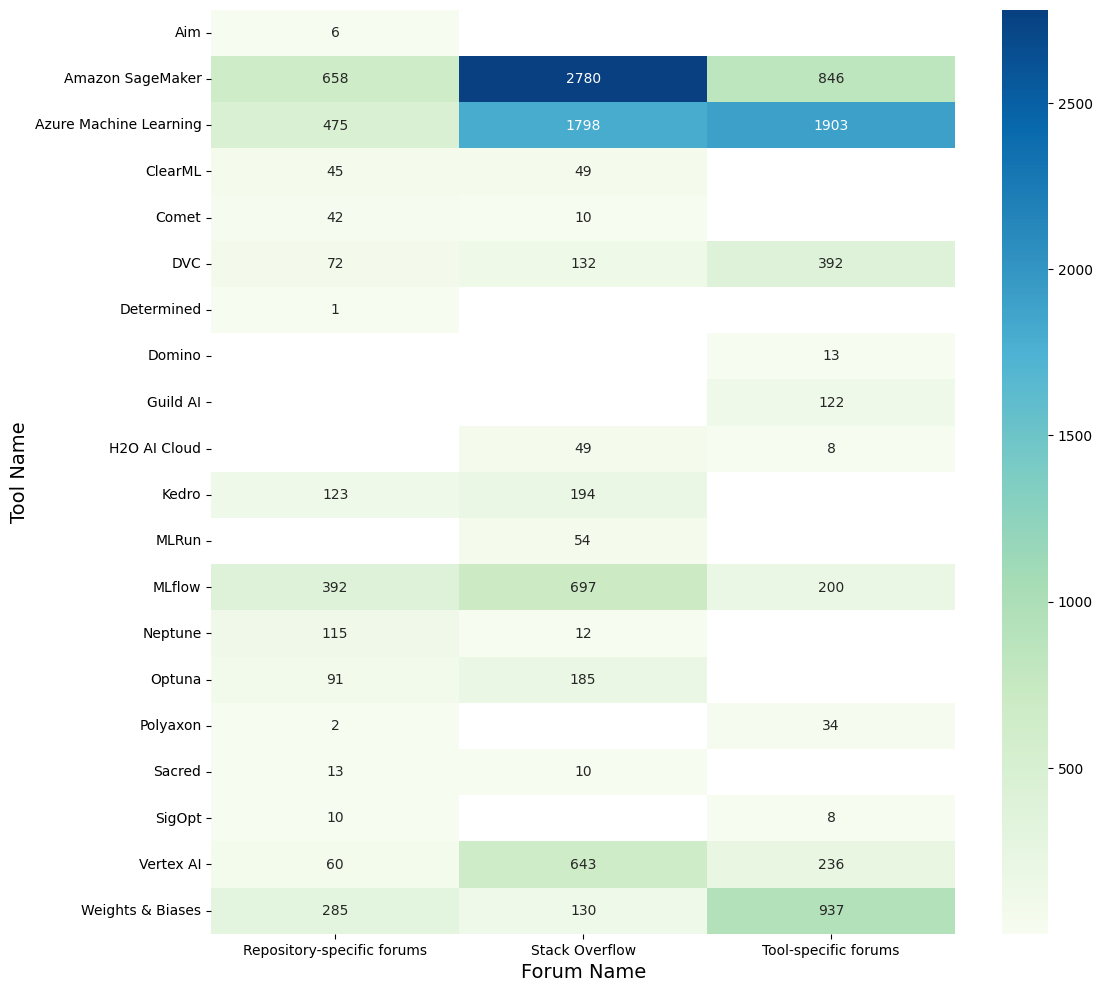

In [6]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df.explode('Tools')
df = df[['Platform', 'Tools']].value_counts().reset_index(name='count')

plt.figure(figsize=(12, 12))
df_heatmap = df.pivot_table(values='count', index='Tools', columns='Platform', aggfunc=np.sum)
ax = sns.heatmap(df_heatmap, cmap="GnBu", annot=True, fmt='g')
ax.set_xlabel('Forum Name', fontsize=14)
ax.set_ylabel('Tool Name', fontsize=14)
plt.savefig(os.path.join(path_rq3, 'Platform tool heatmap.pdf'), bbox_inches='tight')
plt.show()

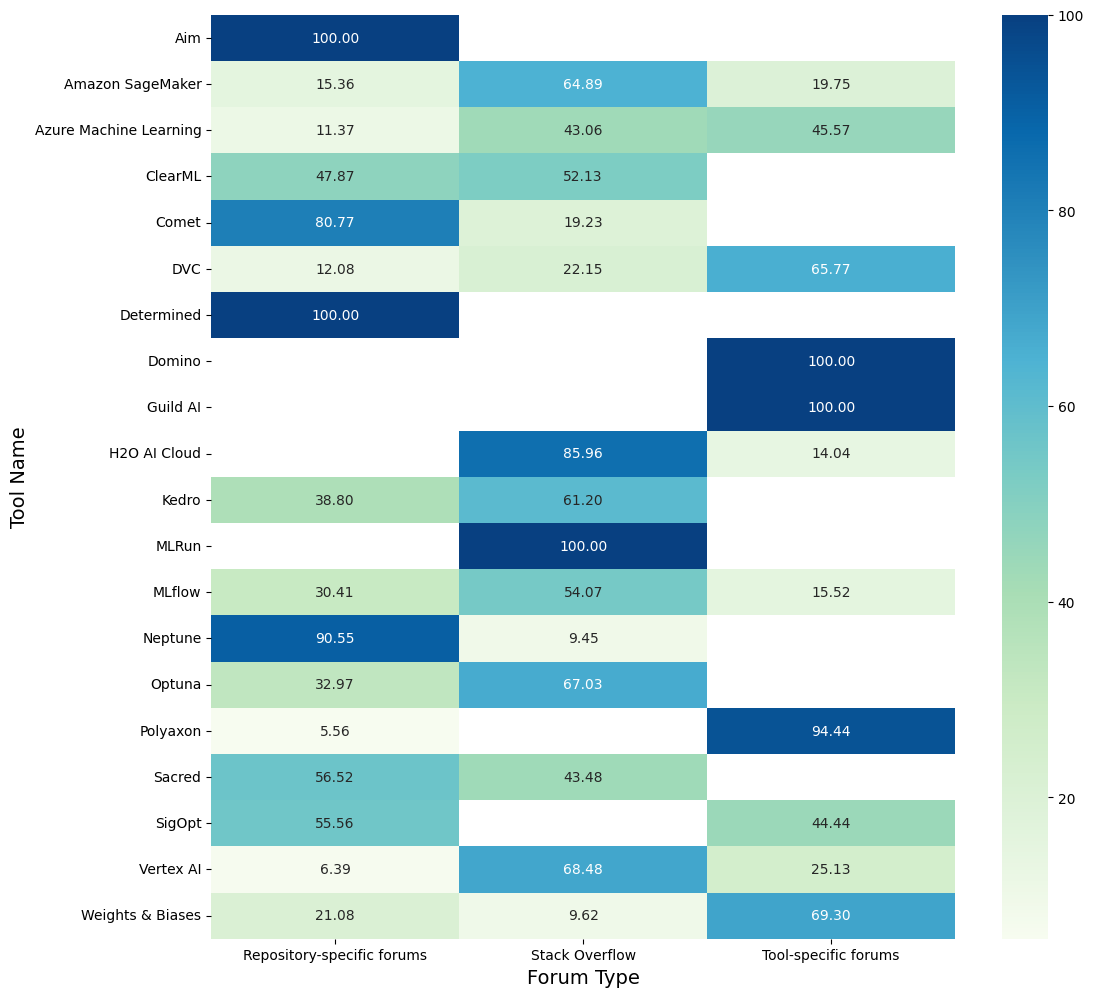

In [4]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df.explode('Tools')
df = df[['Platform', 'Tools']].value_counts().reset_index(name='count')

df_grouped = df.groupby('Tools')['count'].sum().reset_index()
df_grouped.rename(columns={'count': 'sum'}, inplace=True)
df_merged = pd.merge(df, df_grouped, on='Tools')
df_merged['normalized_count'] = df_merged['count'] / df_merged['sum'] * 100

plt.figure(figsize=(12, 12))
df_heatmap = df_merged.pivot_table(values='normalized_count', index='Tools', columns='Platform', aggfunc=np.sum)
ax = sns.heatmap(df_heatmap, cmap="GnBu", annot=True, fmt='.2f')
ax.set_xlabel('Forum Type', fontsize=14)
ax.set_ylabel('Tool Name', fontsize=14)
plt.savefig(os.path.join(path_rq3, 'Platform tool heatmap (percentage).pdf'), bbox_inches='tight')
plt.show()

In [13]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))

for forum_name, forum_posts in df.groupby('Platform'):
    df_inquiry = []

    for name, group in forum_posts.groupby('Challenge_type'):
        group_filtered = filter_open_posts(group)
        info = {
            'Type': name,
            'Prevalence (%)': round(len(group) / len(forum_posts) * 100, 2),
            'Unresolved rate (%)': round(group_filtered['Challenge_closed_time'].isna().sum() / len(group_filtered) * 100, 2),
            'Median resolved time (h)': round(group['Challenge_resolved_time'].median(), 2),
        }
        df_inquiry.append(info)

    df_inquiry = pd.DataFrame(df_inquiry)
    print(forum_name)
    print(df_inquiry.to_latex(index=False, escape=True, float_format="%.2f"))

GitHub
\begin{tabular}{lrrr}
\toprule
Type & Prevalence (%) & Unresolved rate (%) & Median resolution time (hours) \\
\midrule
knowledge & 13.77 & 39.94 & 204.00 \\
problem & 86.23 & 28.82 & 219.88 \\
\bottomrule
\end{tabular}

Stack Overflow
\begin{tabular}{lrrr}
\toprule
Type & Prevalence (%) & Unresolved rate (%) & Median resolution time (hours) \\
\midrule
knowledge & 45.31 & 63.98 & 22.92 \\
problem & 54.69 & 69.72 & 25.36 \\
\bottomrule
\end{tabular}

Tool-specific Forums
\begin{tabular}{lrrr}
\toprule
Type & Prevalence (%) & Unresolved rate (%) & Median resolution time (hours) \\
\midrule
knowledge & 47.33 & 72.68 & 11.62 \\
problem & 52.67 & 83.18 & 14.90 \\
\bottomrule
\end{tabular}



In [12]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

for forum_name, forum_posts in df.groupby('Platform'):
    forum_posts_k = forum_posts[forum_posts['Challenge_type'] == 'knowledge']
    forum_posts_p = forum_posts[forum_posts['Challenge_type'] == 'problem']
    eta, p = etaSquared_p([forum_posts_k['Challenge_resolved_time'], forum_posts_p['Challenge_resolved_time']])
    print(f"{forum_name}: p={p}, eta={eta}")

Repository-specific forums: p=0.4471968627623988, eta=0.000355317832572616
Stack Overflow: p=0.943999475119396, eta=2.245887930435032e-06
Tool-specific forums: p=0.10160411933522903, eta=0.0031237551771508536


In [8]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))

for forum_name, forum_posts in df.groupby('Platform'):
    df_inquiry = []

    for name, group in forum_posts.groupby('Challenge_topic_macro'):
        group_filtered = filter_open_posts(group)
        info = {
            'Macro-topic': macro_topic_indexing[name],
            'Prevalence (%)': round(len(group) / len(forum_posts) * 100, 2),
            'Unresolved rate (%)': round(group_filtered['Challenge_closed_time'].isna().sum() / len(group_filtered) * 100, 2),
            'Median resolved time (h)': round(group['Challenge_resolved_time'].median(), 2),
        }
        df_inquiry.append(info)

    df_inquiry = pd.DataFrame(df_inquiry)
    print(forum_name)
    df_inquiry.sort_values(by='Prevalence (%)', ascending=False, inplace=True)
    print(df_inquiry.to_latex(index=False, escape=True, float_format="%.2f"))

Repository-specific forums
\begin{tabular}{lrrr}
\toprule
Macro-topic & Prevalence (%) & Unresolved rate (%) & Median resolved time (h) \\
\midrule
Environment Management & 25.53 & 29.90 & 220.90 \\
Model Development & 9.71 & 30.13 & 194.87 \\
Computation Management & 9.54 & 32.44 & 236.34 \\
Observability Management & 8.18 & 23.83 & 221.94 \\
Pipeline Management & 6.87 & 37.04 & 216.07 \\
Model Deployment & 6.45 & 31.58 & 295.70 \\
Data Management & 5.98 & 25.53 & 172.97 \\
Model Management & 5.77 & 39.71 & 166.93 \\
File Management & 5.39 & 34.65 & 288.54 \\
Network Management & 3.82 & 30.00 & 271.32 \\
Experiment Management & 3.73 & 22.73 & 168.60 \\
Security Management & 3.18 & 34.67 & 122.13 \\
Code Development & 3.01 & 32.39 & 70.89 \\
Data Development & 1.36 & 50.00 & 474.13 \\
User Interface Management & 0.98 & 17.39 & 113.55 \\
Code Management & 0.51 & 16.67 & 574.32 \\
\bottomrule
\end{tabular}

Stack Overflow
\begin{tabular}{lrrr}
\toprule
Macro-topic & Prevalence (%) & Unre

In [9]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df_platform = {}

for forum_name, forum_posts in df.groupby('Platform'):
    df_inquiry = []

    for name, group in forum_posts.groupby('Challenge_topic_macro'):
        group_filtered = filter_open_posts(group)
        topic_info = {
            'Macro-topic': macro_topic_indexing[name],
            'Number': len(group),
            'Unresolved rate (%)': group_filtered['Challenge_closed_time'].isna().sum() / len(group_filtered) * 100,
        }
        df_inquiry.append(topic_info)

    df_inquiry = pd.DataFrame(df_inquiry)
    df_platform[forum_name] = df_inquiry

df_final= []
keys = list(df_platform.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        key1, value1 = keys[i], df_platform[keys[i]]
        key2, value2 = keys[j], df_platform[keys[j]]
        contingency_prevalence = np.array([value1['Number'], value2['Number']])
        contingency_unresolved_rate = np.array([value1['Unresolved rate (%)'], value2['Unresolved rate (%)']])
        entry = {
            'Number (p-value)': CramersV_p(contingency_prevalence)[1],
            'Number (Cramers-V)': CramersV_p(contingency_prevalence)[0],
            # 'Unresolved rate (p-value)': chi2_contingency(contingency_unresolved_rate).pvalue, 
            # 'Unresolved rate (Cramers-V)': CramersV_p(contingency_unresolved_rate)[0], 
        }
        entry = pd.Series(entry, name=f"{key1} vs. {key2}")
        df_final.append(entry)
        
df_final = pd.DataFrame(df_final)
for column in df_final.columns:
    if 'p-value' in column:
        df_final[column] = fdrcorrection(df_final[column])[1]
print(df_final.to_latex(index=False, escape=True, float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
 & Number (p-value) & Number (Cramers-V) \\
\midrule
Repository-specific forums vs. Stack Overflow & 0.000 & 0.177 \\
Repository-specific forums vs. Tool-specific forums & 0.000 & 0.169 \\
Stack Overflow vs. Tool-specific forums & 0.000 & 0.132 \\
\bottomrule
\end{tabular}



In [23]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

df_git = df[df['Platform'] == repo]
df_so = df[df['Platform'] == stackoverflow]
df_tool = df[df['Platform'] == tool]

p_values = []
eta_squared = []


eta, p = etaSquared_p([df_git['Challenge_resolved_time'], df_so['Challenge_resolved_time']])
p_values.append(p)
eta_squared.append(eta)

eta, p = etaSquared_p([df_so['Challenge_resolved_time'], df_tool['Challenge_resolved_time']])
p_values.append(p)
eta_squared.append(eta)

eta, p = etaSquared_p([df_tool['Challenge_resolved_time'], df_git['Challenge_resolved_time']])
p_values.append(p)
eta_squared.append(eta)

p_values = fdrcorrection(p_values)[1]
print(f"GitHub vs Stack Overflow: p={p_values[0]}, eta-squared={eta_squared[0]}")
print(f"Stack Overflow vs Tool-specific: p={p_values[1]}, eta-squared={eta_squared[1]}")
print(f"Tool-specific vs GitHub: p={p_values[2]}, eta-squared={eta_squared[2]}")

GitHub - Stack Overflow: p=1.0036569291005878e-103, eta-squared=0.12310318663662194
Stack Overflow - Tool-specific: p=5.612108058048202e-12, eta-squared=0.015530296194799226
Tool-specific - GitHub: p=7.933751481316485e-115, eta-squared=0.21116275163487108


In [9]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

for forum_name, forum_posts in df.groupby('Platform'):
    df_problem = forum_posts[forum_posts['Challenge_type'] == 'problem']['Challenge_resolved_time'].tolist()
    df_knowledge = forum_posts[forum_posts['Challenge_type'] == 'knowledge']['Challenge_resolved_time'].tolist()

    print(forum_name)
    print("P-value of two type of inquiries:", mannwhitneyu(df_problem, df_knowledge)[1])
    print()


GitHub
P-value of two type of inquiries: 0.820471237217124

Stack Overflow
P-value of two type of inquiries: 0.9440262256169768

Tool-specific Forums
P-value of two type of inquiries: 0.1016332564510755



In [24]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))

forum_names = []
p_values = []
V_values = []

for forum_name, forum_posts in df.groupby('Platform'):
    forum_names.append(forum_name)
    values_k = []
    values_p = []

    for index, group in forum_posts.groupby('Challenge_topic_macro'):
        group_k = group[group['Challenge_type'] == 'knowledge']
        group_p = group[group['Challenge_type'] == 'problem']
        values_k.append(len(group_k))
        values_p.append(len(group_p))
    
    contingency_table = np.array([values_k, values_p])
    V, p = CramersV_p(contingency_table)
    p_values.append(p)
    V_values.append(V)
    
p_values = fdrcorrection(p_values)[1]
for forum_name, p, V in zip(forum_names, p_values, V_values):
    print(f"{forum_name}: p={p}, V={V}")

GitHub: p=0.006896855813037444, V=0.11729271860472812
Stack Overflow: p=3.2996557219826976e-12, V=0.11482651832986955
Tool-specific Forums: p=3.769152431152482e-14, V=0.1459746358755551


In [ ]:
# df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
# # df = df[df['Challenge_resolved_time'].notna()]

# difficulty = ['Unresolved rate (%)', 'Median resolved time (h)']
# prevalence = ['Prevalence (%)', 'Mean score count', 'Mean readability', 'Mean reading time (s)', 'Mean link count', 'Mean code count']
# extra_columns = {
#     'General Discussion Forum': ['Challenge_comment_count', 'Challenge_comment_readability', 'Challenge_comment_reading_time', 'Challenge_comment_link_count', 'Challenge_favorite_count', 'Challenge_view_count', 'Poster_reputation_count', 'Poster_view_count'],
#     'Repo-specific Discussion Forum': ['Challenge_comment_count', 'Challenge_comment_readability', 'Challenge_comment_reading_time', 'Challenge_comment_link_count', 'Challenge_contributor_issue_ratio', 'Challenge_repo_contributor_count', 'Challenge_repo_fork_count', 'Challenge_repo_issue_count', 'Challenge_repo_star_count', 'Challenge_repo_watch_count', 'Challenge_watch_issue_ratio'],
#     'Tool-specific Discussion Forum': [],
# }

# for forum_name, forum_posts in df.groupby('Platform'):
#     df_number = pd.DataFrame()

#     for index, group in forum_posts.groupby('Challenge_topic'):
#         entry = {
#         'Index': index + 1,
#         'Prevalence (%)': round(len(group)/len(df)*100, 2),
#         'Mean score count': round(group['Challenge_score_count'].mean(), 2),
#         'Mean readability': round(group['Challenge_readability'].mean(), 2),
#         'Mean reading time (s)': round(group['Challenge_reading_time'].mean(), 2),
#         'Mean link count': round(group['Challenge_link_count'].mean(), 2),
#         'Mean code count': round(group['Challenge_code_count'].mean(), 2),
#         'Unresolved rate (%)': round(len(group[group['Challenge_resolved_time'].isna()])/len(group)*100, 2),
#         'Median resolved time (h)': round(group['Challenge_resolved_time'].median(), 2),
#         }
#         for column in extra_columns[forum_name]:
#             entry[f"Mean {' '.join(column.split('_')[1:])}"] = round(group[column].mean(), 2)
#         df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

#     df_test = []
    
#     extra_prevalence = [f"Mean {' '.join(column.split('_')[1:])}" for column in extra_columns[forum_name]]

#     for column_d in difficulty:
#         for column_p in prevalence + extra_prevalence:
#             tau, pvalue = kendalltau(df_number[column_d], df_number[column_p])
#             kendall_tau = pd.Series({'Metrics': f'{column_d}-{column_p}', 'tau': tau, 'p-value': pvalue})
#             df_test.append(kendall_tau)
#     df_test = pd.DataFrame(df_test)
#     print(df_test.to_latex(index=False, escape=True, float_format="%.3f"))

In [5]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = filter_open_posts(df)
df['Challenge_topic_macro'] = df['Challenge_topic_macro'].apply(lambda x: macro_topic_indexing[x])

n = len(df['Challenge_type'].unique())
fig = make_subplots(rows=n, cols=1, shared_xaxes=False, vertical_spacing=0.12)

for i, (type, type_group) in enumerate(df.groupby('Challenge_type')):
    show_legend = True if i == 0 else False
    for forum_name, forum_group in type_group.groupby('Platform'):
        categories = []
        rates = []
        
        for name, topic_group in forum_group.groupby('Challenge_topic_macro'):
            categories.append(name)
            rates.append(len(topic_group))
            
        fig.add_trace(go.Bar(
            x=categories, 
            y=rates, 
            name=forum_name, 
            showlegend=show_legend,
            marker_color=color_map[forum_name],
            text=rates, 
            textposition='outside'), 
        row=i+1, 
        col=1)
        if i == n - 1:
            fig.update_xaxes(title_text=f'Challenge Macro-topics', title_font=dict(size=20), row=i+1, col=1)
        fig.update_yaxes(title_text=f'Frequency ({type} inquiry)', title_font=dict(size=20), row=i+1, col=1)

fig.update_layout(
    width=1000, 
    height=1000,
    margin=go.layout.Margin(
        l=20,  # left margin
        r=20,  # right margin
        b=20,  # bottom margin
        t=20,  # top margin
    ),
    legend_title='Discussion Forum',
    boxmode='group',
)
fig.show()
pio.full_figure_for_development(fig, warn=False)
fig.write_image(os.path.join(path_rq3, 'Macro-topics frequency histogram.pdf'), engine="kaleido")


In [6]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = filter_open_posts(df)
df['Challenge_topic_macro'] = df['Challenge_topic_macro'].apply(lambda x: macro_topic_indexing[x])

n = len(df['Challenge_type'].unique())
fig = make_subplots(rows=n, cols=1, shared_xaxes=False, vertical_spacing=0.12)

for i, (type, type_group) in enumerate(df.groupby('Challenge_type')):
    show_legend = True if i == 0 else False
    for forum_name, forum_group in type_group.groupby('Platform'):
        categories = []
        rates = []
        
        for name, topic_group in forum_group.groupby('Challenge_topic_macro'):
            categories.append(name)
            rates.append(round(topic_group['Challenge_closed_time'].isna().sum() / len(topic_group) * 100, 2))
            
        fig.add_trace(go.Bar(
            x=categories, 
            y=rates, 
            name=forum_name, 
            showlegend=show_legend,
            marker_color=color_map[forum_name],
            text=rates, 
            textposition='outside'), 
        row=i+1, 
        col=1)
        if i == n - 1:
            fig.update_xaxes(title_text=f'Challenge Macro-topics', title_font=dict(size=20), row=i+1, col=1)
        fig.update_yaxes(title_text=f'Unresolved Rate ({type} inquiry)', title_font=dict(size=20), row=i+1, col=1)

fig.update_layout(
    width=1000, 
    height=1000,
    margin=go.layout.Margin(
        l=20,  # left margin
        r=20,  # right margin
        b=20,  # bottom margin
        t=20,  # top margin
    ),
    legend_title='Discussion Forum',
    boxmode='group' 
)
fig.show()
fig.write_image(os.path.join(path_rq3, 'Macro-topics unresolved rate histogram.pdf'))


In [14]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = filter_open_posts(df)

forum_names = []
p_values = []

for forum_name, forum_posts in df.groupby('Platform'):
    resolved_rate_list = []

    for name, group in forum_posts.groupby('Challenge_topic_macro'):
        resolved_rate_list.append(group['Challenge_resolved_time'].isna().sum()/len(group)*100)

    contingency_table = np.array(resolved_rate_list)
    forum_names.append(forum_name)
    p_values.append(chi2_contingency(contingency_table)[1])
    
p_values = fdrcorrection(p_values)[1]
for forum_name, p_value in zip(forum_names, p_values):
    print(f"{forum_name}: {p_value}")


GitHub: 1.0
Stack Overflow: 1.0
Tool-specific Forums: 1.0


In [32]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

for forum_name, forum_posts in df.groupby('Platform'):
    df_test = []

    for macro_name, macro_group in forum_posts.groupby('Challenge_topic_macro', sort=True):
        frequency_p = []
        frequency_k = [] 
    
        for name, group in macro_group.groupby('Challenge_topic'):
            frequency_p.append(len(group[group['Challenge_type'] == 'problem']))
            frequency_k.append(len(group[group['Challenge_type'] == 'knowledge']))
        contingency_table = np.array([frequency_p, frequency_k])
        try:
            V, p = CramersV_p(contingency_table)
        except:
            V, p = 0, 1
        test = {
            'Macro-topic': macro_topic_indexing[macro_name],
            'p-value': p,
            "Cramer's V": V,
        }
        df_test.append(test)

    df_test = pd.DataFrame(df_test)
    df_test['p-value'] = fdrcorrection(df_test['p-value'])[1]
    print('Table Name:', forum_name)
    print(df_test.to_latex(index=False, escape=True, float_format="%.3f"))


Table Name: GitHub
\begin{tabular}{lrr}
\toprule
Macro-topic & p-value & Cramer's V \\
\midrule
Code Development & 0.883 & 0.153 \\
Code Management & 1.000 & NaN \\
Compute Management & 0.155 & 0.335 \\
Data Development & 1.000 & 0.198 \\
Data Management & 0.732 & 0.354 \\
Environment Management & 0.207 & 0.289 \\
Experiment Management & 1.000 & 0.000 \\
File Management & 0.732 & 0.317 \\
Model Development & 0.589 & 0.431 \\
Model Management & 0.589 & 0.279 \\
Model Deployment & 0.883 & 0.321 \\
Network Management & 0.321 & 0.430 \\
Observability Management & 1.000 & 0.178 \\
Pipeline Management & 0.407 & 0.332 \\
Security Management & 0.104 & 0.551 \\
User Interface Management & 1.000 & NaN \\
\bottomrule
\end{tabular}

Table Name: Stack Overflow
\begin{tabular}{lrr}
\toprule
Macro-topic & p-value & Cramer's V \\
\midrule
Code Development & 0.246 & 0.276 \\
Code Management & 1.000 & NaN \\
Compute Management & 0.248 & 0.288 \\
Data Development & 0.123 & 0.283 \\
Data Management & 0.01

In [33]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = filter_open_posts(df)

forum_names = []
p_values = []

for forum_name, forum_posts in df.groupby('Platform'):
    values_k = []
    values_p = []

    for index, group in forum_posts.groupby('Challenge_topic_macro'):
        group_k = group[group['Challenge_type'] == 'knowledge']
        group_p = group[group['Challenge_type'] == 'problem']
        values_k.append(group_k['Challenge_resolved_time'].isna().sum()/len(group_k)*100)
        values_p.append(group_p['Challenge_resolved_time'].isna().sum()/len(group_p)*100)

    contingency_table = np.array([values_k, values_p])
    forum_names.append(forum_name)
    p_values.append(chi2_contingency(contingency_table)[1])
    
p_values = fdrcorrection(p_values)[1]
for forum_name, p_value in zip(forum_names, p_values):
    print(f"{forum_name}: {p_value}")

GitHub: 5.029820137503741e-06
Stack Overflow: 0.9910183962810059
Tool-specific Forums: 0.9910183962810059


In [4]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df.sort_values('Challenge_topic_macro')
df['Challenge_resolved_time'] = df['Challenge_resolved_time'].apply(lambda x: np.log(x+1))
df['Challenge_topic_macro'] = df['Challenge_topic_macro'].apply(lambda x: macro_topic_indexing[x])

n = len(df['Challenge_type'].unique())
fig = make_subplots(rows=n, cols=1, shared_xaxes=False, vertical_spacing=0.12)

for i, (type, group) in enumerate(df.groupby('Challenge_type')):
    temp_fig = px.box(group, x="Challenge_topic_macro", y="Challenge_resolved_time", color="Platform")
    for trace in temp_fig.data:       
        trace.showlegend = True if i == 0 else False
        fig.add_trace(trace, row=i+1, col=1)
    if i == n - 1:
        fig.update_xaxes(title_text=f'Challenge Macro-topics', title_font=dict(size=20), row=i+1, col=1)
    fig.update_yaxes(title_text=f'Resolution Time ({type} inquiry)', title_font=dict(size=20), row=i+1, col=1)

fig.update_layout(
    width=1000, 
    height=1000,
    margin=go.layout.Margin(
        l=20,  # left margin
        r=20,  # right margin
        b=20,  # bottom margin
        t=20,  # top margin
    ),
    legend_title='Discussion Forum',
    boxmode='group' 
)
fig.show()
fig.write_image(os.path.join(path_rq3, f'Macro-topics resolution time boxplot.pdf'))


In [34]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

for forum_name, forum_posts in df.groupby('Platform'):
    df_test = []

    for index, group in forum_posts.groupby('Challenge_topic_macro'):
        group_k = group[group['Challenge_type'] == 'knowledge']
        group_p = group[group['Challenge_type'] == 'problem']
        try:
            eta, p = etaSquared_p([group_k['Challenge_resolved_time'], group_p['Challenge_resolved_time']])
        except:
            eta, p = 0, 1
        test = {
            'Macro-topic': macro_topic_indexing[index],
            'p-value': p_value,
            'eta-squared': eta,
        }
        df_test.append(test)

    df_test = pd.DataFrame(df_test)
    df_test['p-value'] = fdrcorrection(df_test['p-value'])[1]
    print(forum_name)
    print(df_test.to_latex(index=False, escape=True, float_format="%.3f"))


GitHub
\begin{tabular}{lrr}
\toprule
Macro-topic & p-value & eta-squared \\
\midrule
Code Development & 0.991 & 0.000 \\
Code Management & 0.991 & 0.000 \\
Compute Management & 0.991 & 0.000 \\
Data Development & 0.991 & 0.381 \\
Data Management & 0.991 & 0.003 \\
Environment Management & 0.991 & 0.003 \\
Experiment Management & 0.991 & 0.089 \\
File Management & 0.991 & 0.001 \\
Model Development & 0.991 & 0.011 \\
Model Management & 0.991 & 0.009 \\
Model Deployment & 0.991 & 0.000 \\
Network Management & 0.991 & 0.002 \\
Observability Management & 0.991 & 0.002 \\
Pipeline Management & 0.991 & 0.001 \\
Security Management & 0.991 & 0.001 \\
User Interface Management & 0.991 & 0.002 \\
\bottomrule
\end{tabular}

Stack Overflow
\begin{tabular}{lrr}
\toprule
Macro-topic & p-value & eta-squared \\
\midrule
Code Development & 0.991 & 0.003 \\
Code Management & 0.991 & 0.168 \\
Compute Management & 0.991 & 0.008 \\
Data Development & 0.991 & 0.032 \\
Data Management & 0.991 & 0.000 \\
Env

In [26]:
df = pd.read_json(os.path.join(path_rq3, 'forums.json'))
df = df[df['Challenge_resolved_time'].notna()]

forum_names = []
p_values = []
eta_squared = []

for forum_name, forum_posts in df.groupby('Platform'):
    resolved_time_list = []

    for name, group in forum_posts.groupby('Challenge_topic_macro'):
        resolved_time_list.append(group['Challenge_resolved_time'])

    forum_names.append(forum_name)
    eta, p = etaSquared_p(resolved_time_list)
    eta_squared.append(eta)
    p_values.append(p)
    
p_values = fdrcorrection(p_values)[1]
for forum_name, p_value in zip(forum_names, p_values):
    print(forum_name)
    print(f"Kruskal-Wallis H-test: p={p_value}, eta-squared={eta_squared[forum_names.index(forum_name)]}")
    print()


GitHub
Kruskal-Wallis H-test: p=0.4224104932318112, eta-squared=0.009582413436149075

Stack Overflow
Kruskal-Wallis H-test: p=0.006125790174513364, eta-squared=0.015218780108463621

Tool-specific Forums
Kruskal-Wallis H-test: p=0.002249371830845884, eta-squared=0.04492133163537184

